In [1]:
import pandas as pd
import geopandas as gpd
import folium
from folium import GeoJson
from math import log
import sys
import os

sys.path.append(os.path.abspath('../../../scripts/2. modules'))
import processing
import analysis

# Inputs
HISTORICAL_DATA_PATH = '../../../data/3. curated/merged/all_historical_data.csv'

# keep within 2016, 3 up to 2019, 4 to cover all datasets
START_YEAR = 2016
START_QUARTER = 3
END_YEAR = 2019
END_QUARTER = 4

Read in the data

In [4]:
DWELLING_COMBINATIONS = [
    ('house', '2'), ('house', '3'), ('house', '4'), ('flat', '1'), ('flat', '2'), ('flat', '3'), ('all', 'all')
]

housing_df = pd.read_csv(HISTORICAL_DATA_PATH)
regions_df = processing.get_regions_df(3)

Functions

We being by doing a naieve exploration of the correlation of each feature:

In [25]:
CORRELATIONS_OUTPUT_PATH = '../../../data/4. analysis/correlation'
os.makedirs(CORRELATIONS_OUTPUT_PATH, exist_ok=True)

MEDIAN_IMPUTE = ['housing: count', 'avg_school_median_study_score', 'best_school_number_vce_subjects', 'best_school_median_study_score', 'avg_school_satisfactory_complete_vce_percent', 'housing: median', 'best_school_percentage_applying_to_victorian_uni', 'avg_school_number_vce_subjects', 'best_school_satisfactory_complete_vce_percent', 'avg_school_percentage_applying_to_victorian_uni']

# for each dwelling combination (e.g. house, appartment w x rooms)
for comb in DWELLING_COMBINATIONS:

    # find the correlation for the range with the highest defined dates
    df_filtered = analysis.filter_range(housing_df, START_YEAR, START_QUARTER, END_YEAR, END_QUARTER, 
                               comb[0], comb[1])

    numeric_columns = df_filtered.select_dtypes(include=['number']).columns

    for col in MEDIAN_IMPUTE:
        median = df_filtered[col].median()
        df_filtered[col].fillna(median, inplace=True)

    # Then, filter those columns based on non-missing values
    numeric_non_missing_cols = [col for col in numeric_columns if df_filtered[col].notna().all() and col != 'housing: median']

    correlations = []

    for col in numeric_non_missing_cols:
        if col not in ('housing: median', 'duration_to_cbd'):
            correlations.append((col, float(df_filtered[['housing: median', col]].corr(method='pearson').loc['housing: median', col]),
                                float(df_filtered[['duration_to_cbd', col]].corr(method='pearson').loc['duration_to_cbd', col])))

    pd.DataFrame(correlations, columns=['variable', 'correlation', 'correlation_with_distance']).sort_values('correlation').to_csv(f'{CORRELATIONS_OUTPUT_PATH}/{comb[0]}{comb[1]}correlations.csv')

/tmp/ipykernel_62308/2879170444.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered[col].fillna(median, inplace=True)
/tmp/ipykernel_62308/2879170444.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

Now create scatterplots between features

In [ ]:
CORRELATIONS_OUTPUT_PATH = '../../../plots/scatterplot'

import matplotlib.pyplot as plt

for comb in DWELLING_COMBINATIONS:

    os.makedirs(f'{CORRELATIONS_OUTPUT_PATH}/{comb[0]}-{comb[1]}', exist_ok=True)

    df_filtered = analysis.filter_range(housing_df, START_YEAR, START_QUARTER, END_YEAR, END_QUARTER,
                                comb[0], comb[1]).copy()

    numeric_columns = df_filtered.select_dtypes(include=['number']).columns

    for col in MEDIAN_IMPUTE:
        median = df_filtered[col].median()
        df_filtered[col] = df_filtered[col].fillna(median)

    # Then, filter those columns based on non-missing values
    numeric_non_missing_cols = [col for col in numeric_columns if df_filtered[col].notna().all() and col not in ('Unnamed: 0', 'housing: median')]

    correlations = []

    for col in numeric_non_missing_cols:
        
        plt.scatter(df_filtered[col], df_filtered['housing: median'], s=20, alpha=0.2)

        # Add labels and title
        plt.title(f'Scatter Plot of {col} vs Median Rental Price')
        plt.xlabel(col)
        plt.ylabel('Median Rental Price')

        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Show the plot
        new_col_name = col.replace('/', '')
        plt.savefig(f'{CORRELATIONS_OUTPUT_PATH}/{comb[0]}-{comb[1]}/{new_col_name}_vs_rent.png')
        plt.close()

We also investigate the overall growth of rent overtime.

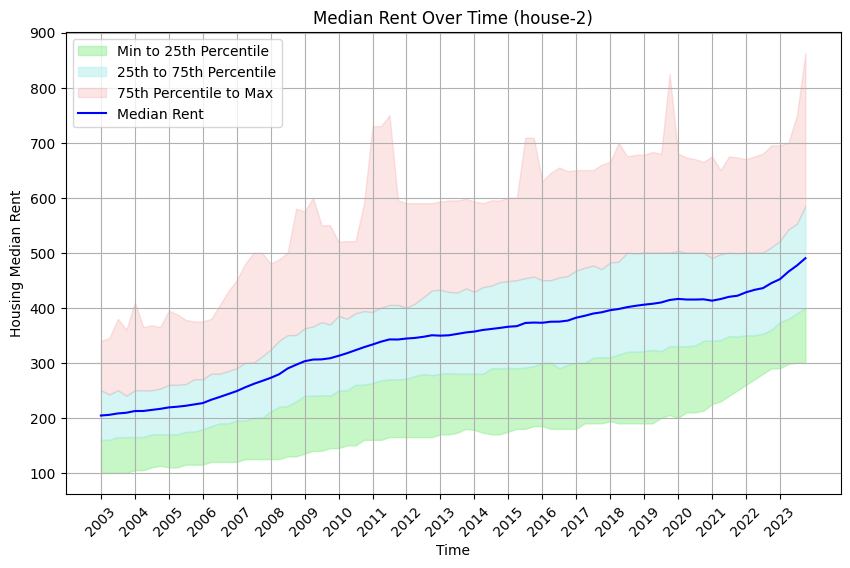

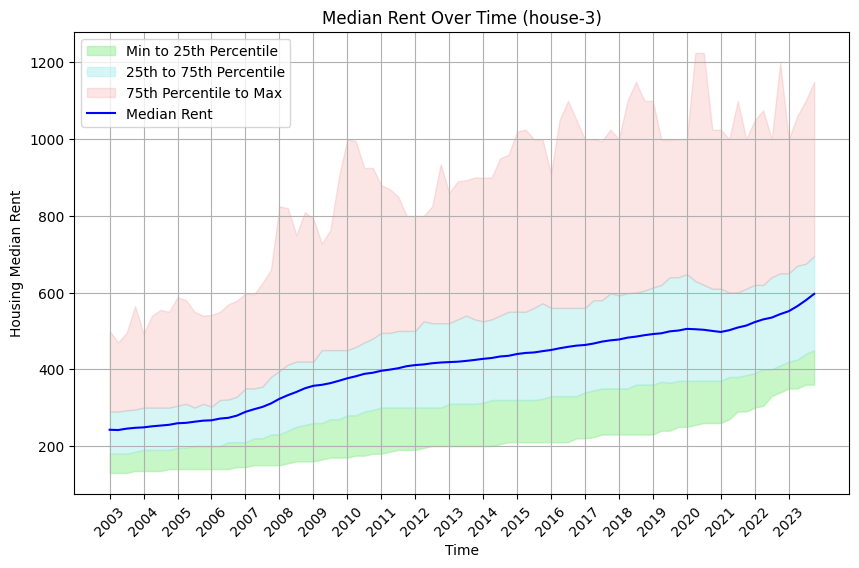

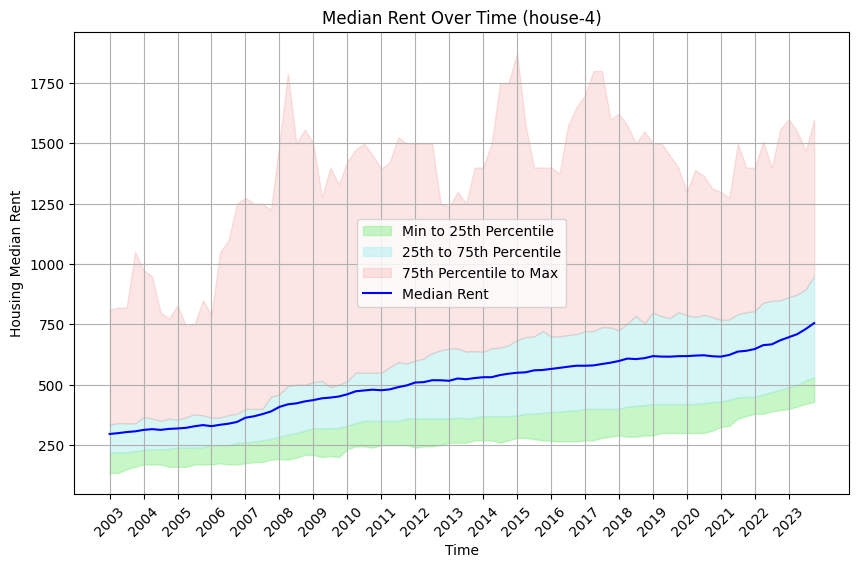

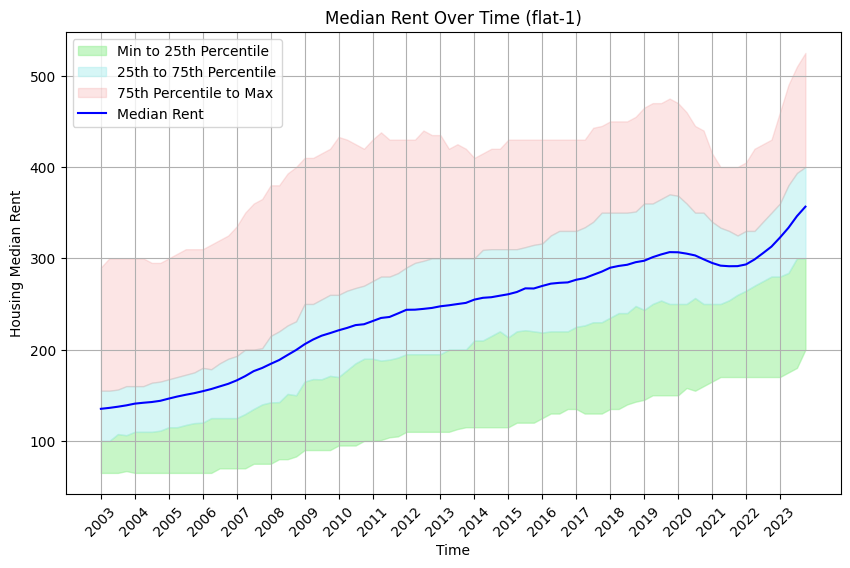

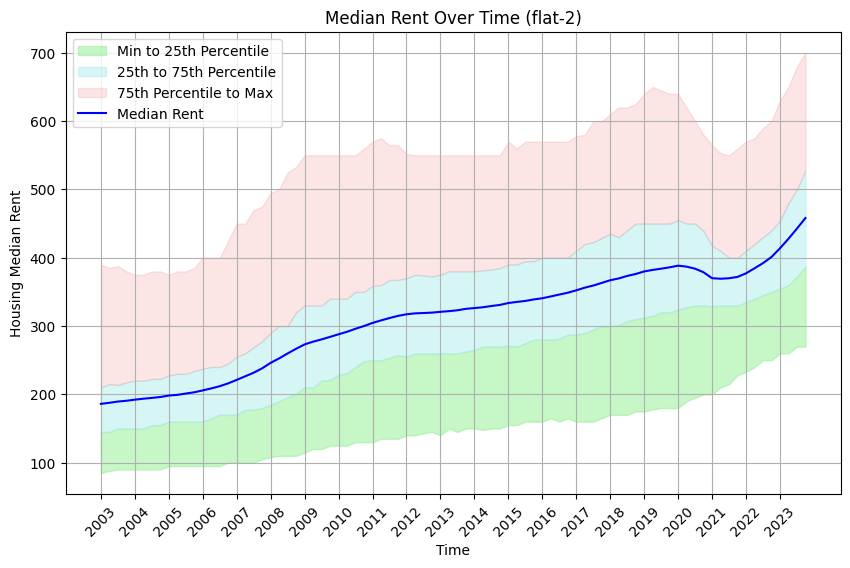

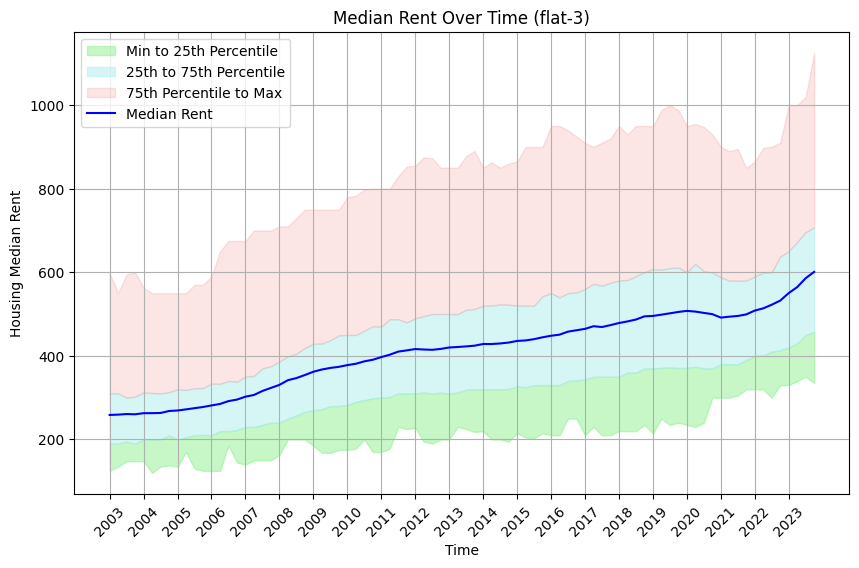

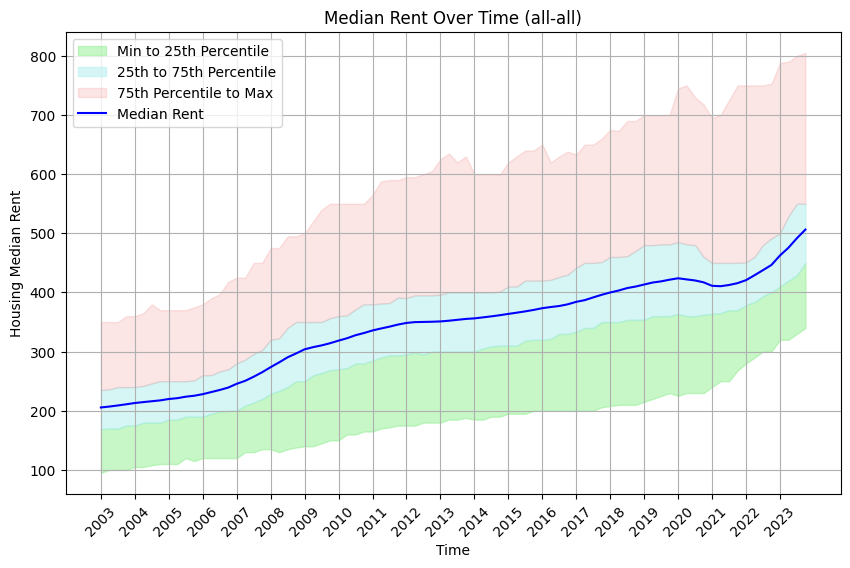

In [5]:
# plot the median rent over time
import matplotlib.pyplot as plt

RENTAL_GROWTH_GRAPH_OUTPUT_PATH = '../../../plots/curated'
os.makedirs(RENTAL_GROWTH_GRAPH_OUTPUT_PATH, exist_ok=True)

START_YEAR = 2003

for comb in DWELLING_COMBINATIONS:
        
    df_filtered = analysis.filter_range(housing_df, START_YEAR, 1, 2023, 4, comb[0], comb[1])

    df_filtered['time'] = (df_filtered['year'] - 2003) * 4 + df_filtered['quarter']

    # Group by 'time' to calculate median, 25th and 75th percentiles
    df_stats = df_filtered.groupby('time')['housing: median'].agg(
        median='mean',            # or you can use median() directly
        min='min',
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75),
        max='max'
    ).reset_index()

    # Plotting
    plt.figure(figsize=(10, 6))

    # Fill areas for quantiles
    plt.fill_between(df_stats['time'], df_stats['min'], df_stats['q25'], color='#90EE90', alpha=0.5, label='Min to 25th Percentile')
    plt.fill_between(df_stats['time'], df_stats['q25'], df_stats['q75'], color='#AEEEEE', alpha=0.5, label='25th to 75th Percentile')
    plt.fill_between(df_stats['time'], df_stats['q75'], df_stats['max'], color='#F08080', alpha=0.2, label='75th Percentile to Max')

    # Plot median rent
    plt.plot(df_stats['time'], df_stats['median'], color='blue', label='Median Rent')

    indices = df_filtered['time'].max()

    tick_labels = [f"{START_YEAR + i // 4}" for i in range(0, indices, 4)]
    tick_positions = range(1, indices + 1, 4)

    plt.xticks(tick_positions, tick_labels, rotation=45)

    # Adding titles and labels
    plt.title(f'Median Rent Over Time ({comb[0]}-{comb[1]})')
    plt.xlabel('Time')
    plt.ylabel('Housing Median Rent')

    plt.legend()
    plt.grid()

    # Show the plot
    plt.savefig(f'{RENTAL_GROWTH_GRAPH_OUTPUT_PATH}/rental_growth_overtime-{comb[0]}-{comb[1]}.png')
    plt.show()

We can clearly see growth has been strong across all housing types. The growth appears mostly linear, with a dramatic spike in the last few years (likely due to COVID). Apartments in particular were affected the most by this, whilst houses continue their linear trend.

In general the rental cheapest listings haven't increased as much, but the really expensive listings has increased dramatically.